# Libraries

In [1]:
#import relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

# Data Loader, Writers

In [6]:
#converts it to 128x128x3 image
def data_augment_resize(image, angle_, w=28, h=28):
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_CUBIC)
    #if angle is 0: no rotn needed
    if angle_ == 1:
        #90 degree rotn
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
    elif angle_ == 2:
        #180 degree rotn
        image = cv2.rotate(image, cv2.ROTATE_180)
    else:
        #270 degree rotn
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return image
        
def save_omligot_dataset(dataloc, lang_labels, saveloc, type_):
    #X, y
    #X = np.array([], dtype='uint8').reshape(0, w, h, 3)
    X = []
    y = []
    
    list_languages = os.listdir(dataloc)
    #read the languages that you need to consider 
    with open(lang_labels, "r") as fptr:
        lang_labels = fptr.read().split("\n")
    
    ctr = 0
    for language in list_languages:
        #consider the split
        if language in lang_labels:
            #this will give a list of all the characters in the language
            lang_chars = os.listdir(dataloc+language)
            for lang_char in lang_chars:
                #reading all the examples of a particular character
                chars = os.listdir(dataloc+language+"/"+lang_char)
                #i*90 : rotation angle
                for i in range(4):
                    y += (np.ones(len(chars), dtype=np.int16)*ctr).tolist()
                    ctr += 1
                    #all the handwritten examples of a particular character
                    for char_img in chars:
                        img = img_to_array(load_img(dataloc+language+"/"+lang_char+"/"+char_img)).astype('uint8')
                        #tell the function to make the size (28, 28), and take appropriate rotn 
                        img = data_augment_resize(img, i)
                        X.append(img)
                
    X = np.array(X)
    y = np.array(y)
    with open(saveloc+type_+"X.npy", 'wb') as fptr:
        np.save(fptr, X)
    with open(saveloc+type_+"y.npy", 'wb') as fptr:
        np.save(fptr, y)

#make the vinyls split and save the datasets
#save_omligot_dataset("./data_omniglot/omniglot/", "./data_omniglot/vinyls/test_files.txt", "./data_omniglot/", "test")
#save_omligot_dataset("./data_omniglot/omniglot/", "./data_omniglot/vinyls/train_files.txt", "./data_omniglot/", "train")

In [7]:
#Display some test images
def display_formatted_image(data_locX, data_locy, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    data = np.load(data_locX)
    print("Number of examples: {}".format(data.shape[0]))
    y = np.load(data_locy)
    print("Number of Labels (charsx4): {}".format(y))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

**Train Set Visualize**

train
Number of examples: 96320
Number of Labels (charsx4): [   0    0    0 ... 4815 4815 4815]


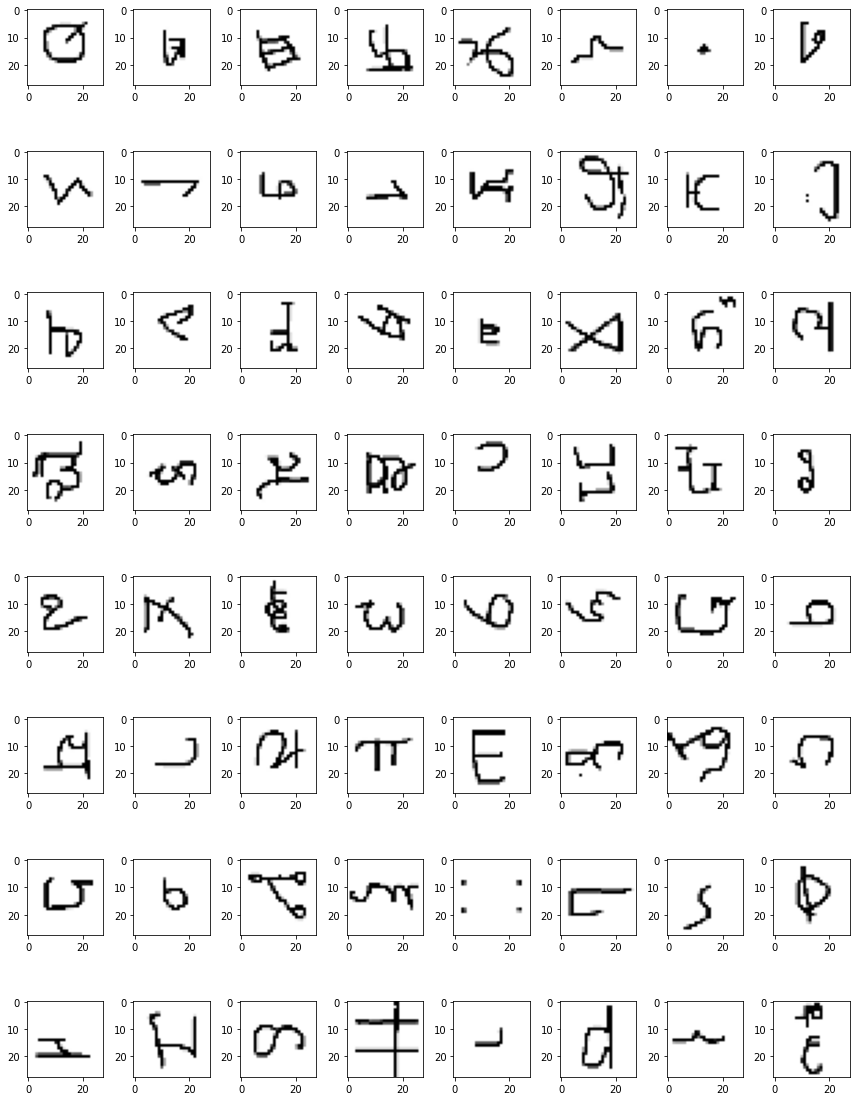

Image dimension in the dataset:  (28, 28, 3)


In [8]:
print("train")
display_formatted_image("./data_omniglot/trainX.npy", "./data_omniglot/trainy.npy", 8, 8)

**Test Set Visualize**

test
Number of examples: 33520
Number of Labels (charsx4): [   0    0    0 ... 1675 1675 1675]


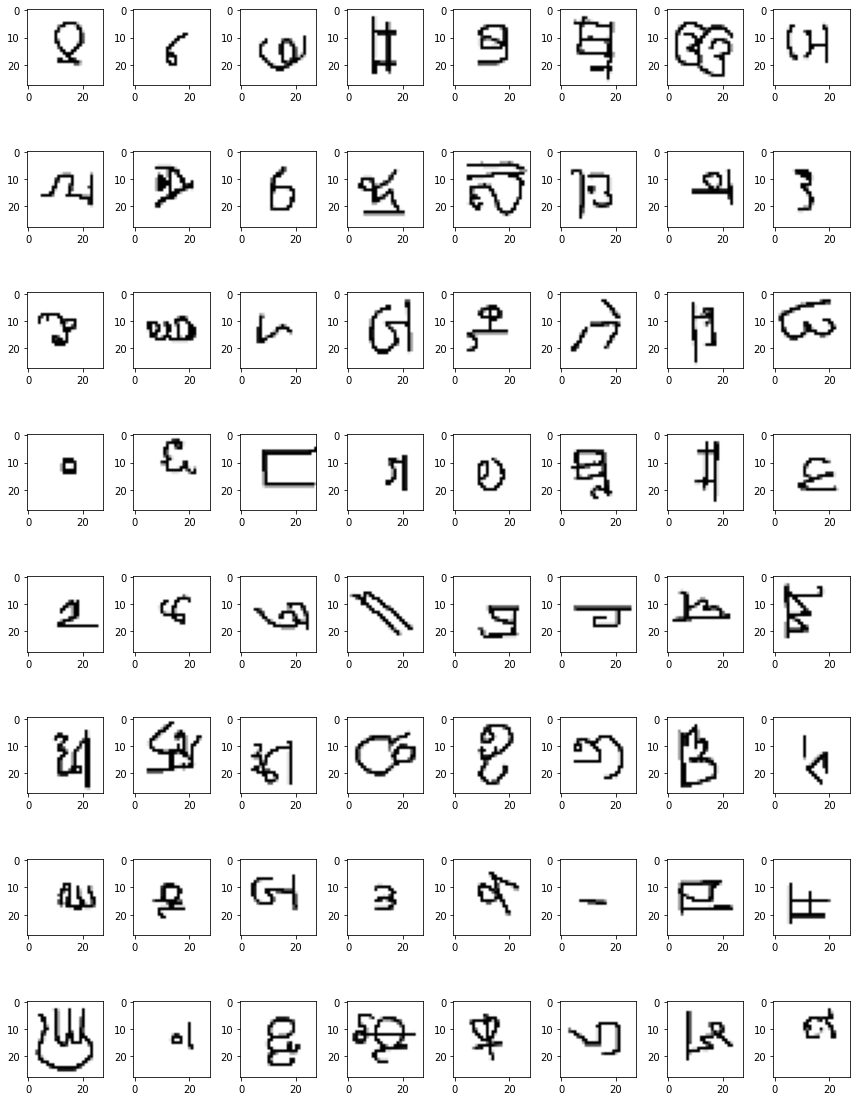

Image dimension in the dataset:  (28, 28, 3)


In [9]:
print("test")
display_formatted_image("./data_omniglot/testX.npy", "./data_omniglot/testy.npy", 8, 8)

# Architecture & Algorithms

**1. Prototypical Nets**

In [10]:
#prototype net: paper followed: https://arxiv.org/abs/1703.05175
class Prototype_Nets(object):
    def __init__(self, inp_shape, N, k):
        self.model = None
        self.inp_shape = inp_shape
        self.arch_hyperparameters = {'l2_conv': 0.000001,
                                     'dropout': 0.002,
                                     'lr': 0.001
                                    }
        self.optimizer = None
        self.lr_schedule = None  
        self.N = N
        self.k = k
        #since y is fixed to speed up the procees (Nk, N) one hot vector to train the network as the order is always the same
        self.scalar_labels = np.repeat(np.arange(self.N), self.k)
        self.y_train_helper = tf.one_hot(self.scalar_labels, self.N)
        
        
        
    def save_model(self, path):
        self.model.save(path+"prototype_net_"+str(self.N)+"way_"+str(self.k)+"shot")
        
    def load_model(self, path, lr=-1):
        self.model = load_model(path+"prototype_net_"+str(self.N)+"way_"+str(self.k)+"shot")
        self.model.compile()
        self.model.summary()
        if lr==-1:
            lr = self.arch_hyperparameters['lr']
        #the paper decreases the learning rate by half
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=2000, decay_rate=0.5, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

    def create_model(self):
        #input
        inp = Input(self.inp_shape, name="input")
        #conv_layer 1
        enc_op = Conv2D(8, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l1')(inp)
        enc_op = MaxPool2D((3,3), strides=(2,2), name='maxpool_l1')(enc_op)
        #14x14
        #conv layer 2
        enc_op = Conv2D(16, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l2')(enc_op)
        enc_op = MaxPool2D((3,3), strides=(2,2), name='maxpool_l2')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l2')(enc_op)
        #7x7
        #conv layer 3
        enc_op = Conv2D(32, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l3')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l3')(enc_op)
        #7x7
        #conv layer 4
        enc_op = Conv2D(64, (2,2), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l4')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l4')(enc_op)
        #6x6
        #conv layer 5
        enc_op = Conv2D(128, (2,2), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l5')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l5')(enc_op)
        #5x5x64
        #Flatten
        enc_op = Flatten(name='flatten')(enc_op)
        #1600
        enc_op = Dropout(self.arch_hyperparameters['dropout'], name='dropout')(enc_op)
        #this has to be a linear transformation
        final_op = Dense(32, name='embedding')(enc_op)
        #32
        self.model = Model(inputs=inp, outputs=final_op, name="encoder_network")
        self.model.compile()
        self.model.summary()
        #the paper decreases the learning rate by half
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(self.arch_hyperparameters['lr'], decay_steps=2000, decay_rate=0.5, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)
    
    def distance(self, z, c):
        #c is of the shape (N, 32)
        #z is of the shape (Nk, 32)
        #Need distance matrix: (N, k, N) : distance of each example in the query to the prototype
        #convert z -> (Nk, 1, 32)
        z = tf.expand_dims(z, axis=1)
        #convert prototype -> (1, N, 32)
        c = tf.expand_dims(c, axis=0)
        #reduce the sum across last dim (Nk, N, 32) -> (Nk, N)
        dmat = tf.sqrt(tf.reduce_sum((z-c)**2, axis=2))
        return dmat
    
    def loss(self, support_set, query_set, to_train): 
        z_support = self.model(support_set, training=to_train)
        z_query = self.model(query_set, training=to_train)
        #find the prototype on the train set, step1: (Nk, 32) reshape (N, k, 32), and then reduce mean across k (axis=k): (N, 32)
        #prototype: c_support
        c_support = tf.reduce_mean(tf.reshape(z_support, (self.N, self.k, z_support.shape[1])), axis=1)
        
        dist_query = -1.0*self.distance(z_query, c_support)
        prob_query = tf.nn.softmax(dist_query, axis=-1)
        
        #loss is the cross entropy loss to maximize the prob of the correct label (log probability)
        loss = -1.0*tf.math.reduce_sum(self.y_train_helper*tf.math.log(prob_query))/(self.k*self.N)
        #accuracy calculation
        pred_y = tf.argmax(prob_query, axis=1).numpy()
        acc = np.sum(pred_y==self.scalar_labels)/(self.N*self.k)
        return loss, acc
    
    def backprop(self, support_set, query_set):
        with tf.GradientTape(persistent=True) as tape:
            loss, acc = self.loss(support_set, query_set, True)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss.numpy(), acc  
    
    def prep_image(self, batch):
        #rescale to [-1, 1], as we will use batch norms later
        batch = batch.astype('float32')
        batch = (2*batch)/255 - 1
        
        return batch
    
    def train_test(self, support_set, query_set, work):
        if work == "train":
            loss, acc = self.backprop(self.prep_image(support_set), self.prep_image(query_set))
        else: #for test
            loss, acc = self.loss(self.prep_image(support_set), self.prep_image(query_set), False)
            loss = loss.numpy()
        return loss, acc

In [7]:
pnet = Prototype_Nets((28, 28, 3), 5, 3)
pnet.create_model()

Model: "encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                                   

**2. MAML: Model-Agnostic Meta-Learning**

In [11]:
#maml: paper followed: https://arxiv.org/abs/1703.03400
class MAML(object):
    def __init__(self, inp_shape, N, k, n_task):
        self.model = None
        self.inp_shape = inp_shape
        #alpha is for the update on the current set
        self.arch_hyperparameters = {'l2_conv': 0.000001,
                                     'dropout': 0.002,
                                     'lr': 0.001,   #it is same as beta
                                     'alpha': 0.05   
                                    }
        self.optimizer = None
        #fixed
        
        #self.support_step = tf.keras.optimizers.SGD(learning_rate=self.arch_hyperparameters['alpha'])
        self.N = N
        self.k = k
        self.n_task = n_task
        #since y is fixed to speed up the procees (Nk, N) one hot vector to train the network as the order is always the same
        self.scalar_labels = np.repeat(np.arange(self.N), self.k)
        self.y_train_helper = tf.one_hot(self.scalar_labels, self.N)
        
    def save_model(self, path):
        self.model.save(path+"maml_net_"+str(self.N)+"way_"+str(self.k)+"shot")
        
    def load_model(self, path, lr=-1):
        self.model = load_model(path+"maml_net_"+str(self.N)+"way_"+str(self.k)+"shot")
        self.model.compile()
        self.model.summary()
        if lr==-1:
            lr = self.arch_hyperparameters['lr']
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.5, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)

    def create_model(self, to_show=True):
        #input
        inp = Input(self.inp_shape, name="input")
        #conv_layer 1
        enc_op = Conv2D(8, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l1')(inp)
        enc_op = MaxPool2D((3,3), strides=(2,2), name='maxpool_l1')(enc_op)
        #14x14
        #conv layer 2
        enc_op = Conv2D(16, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l2')(enc_op)
        enc_op = MaxPool2D((3,3), strides=(2,2), name='maxpool_l2')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l2')(enc_op)
        #7x7
        #conv layer 3
        enc_op = Conv2D(32, (3,3), strides=(1,1), activation='elu', padding='same', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l3')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l3')(enc_op)
        #7x7
        #conv layer 4
        enc_op = Conv2D(64, (2,2), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l4')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l4')(enc_op)
        #6x6
        #conv layer 5
        enc_op = Conv2D(128, (2,2), strides=(1,1), activation='elu', padding='valid', kernel_regularizer=l2(self.arch_hyperparameters['l2_conv']), name = 'conv_l5')(enc_op)
        enc_op = BatchNormalization(name='batch_norm_l5')(enc_op)
        #5x5x64
        #Flatten
        enc_op = Flatten(name='flatten')(enc_op)
        #1600
        enc_op = Dropout(self.arch_hyperparameters['dropout'], name='dropout')(enc_op)
        #this has to be a linear transformation
        final_op = Dense(32, activation='elu', name='embedding')(enc_op)
        #add the output head
        final_op = Dense(self.N, activation='softmax', name='out_head')(final_op)
        #32
        self.model = Model(inputs=inp, outputs=final_op, name="maml_encoder_network")
        self.model.compile()
        if to_show == True:
            self.model.summary()
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(self.arch_hyperparameters['lr'], decay_steps=100, decay_rate=0.5, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)
        
    def loss(self, data_set, to_train, model):
        
        z_data = model(data_set, training=to_train)
            
        #z_data: prob (Nk, N) loss is the cross entropy loss to maximize the prob of the correct label (log probability)
        loss = -1.0*tf.math.reduce_sum(self.y_train_helper*tf.math.log(z_data))/(self.k*self.N)
        #accuracy calculation
        pred_y = tf.argmax(z_data, axis=1).numpy()
        acc = np.sum(pred_y==self.scalar_labels)/(self.N*self.k)
        return loss, acc

    def update_weights_clone(self, model, gradients):
        index = 0 
        #update the weights for the cloned network: \theta_i' = \theta - \alpha*grad
        for i in range(len(model.layers)):
            if hasattr(model.layers[i], 'kernel'):
                model.layers[i].kernel = self.model.layers[i].kernel - self.arch_hyperparameters['alpha']*gradients[index]
                index += 1
            if hasattr(model.layers[i], 'bias'):
                model.layers[i].bias = self.model.layers[i].bias - self.arch_hyperparameters['alpha']*gradients[index]
                index += 1
            #this is to take care of the batchnormalization layer
            if hasattr(model.layers[i], 'gamma'):
                model.layers[i].gamma = self.model.layers[i].gamma - self.arch_hyperparameters['alpha']*gradients[index]
                index += 1
            if hasattr(model.layers[i], 'beta'):
                model.layers[i].beta = self.model.layers[i].beta - self.arch_hyperparameters['alpha']*gradients[index]
                index += 1
                
    def backprop(self, support_set_batch, query_set_batch):
        #the task and the query set is of the following dimension in the implementation: (n_task, Nk, 28, 28, 3) ->model for each task-> (Nk, 5)
        #size of the task batch
        with tf.GradientTape(persistent=True) as tape:
            loss_query_tot = 0
            acc_query_tot = 0
            for i in range(self.n_task):
                #get the current support and query set
                support_set = support_set_batch[i]
                query_set = query_set_batch[i]
                #compute the support loss
                loss_support, _ = self.loss(support_set, True, self.model)
                #derivative 1
                grads_support = tape.gradient(loss_support, self.model.trainable_variables)
                
                #soft inbuilt clone did not work
                #clone_model = tf.keras.models.clone_model(self.model)
                #clone_model.compile()
                #clone_model.set_weights(self.model.get_weights())
                #self.support_step.apply_gradients(zip(grads_support, clone_model.trainable_variables))
                
                #manual hard cloning required
                clone_model_obj = MAML(self.inp_shape, self.N, self.k, self.n_task)
                clone_model_obj.create_model(to_show=False)
                clone_model = clone_model_obj.model
                clone_model.set_weights(self.model.get_weights())
                
                #creates theta_i -= alpha*grad_m
                self.update_weights_clone(clone_model, grads_support)
                
                #compute query loss and accuracy, creates the computation graph on the cloned model
                loss_query, acc_query = self.loss(query_set, True, clone_model)
                loss_query_tot += loss_query
                acc_query_tot += acc_query
        
        #when taking gradients with the model variables: it takes the derivative of the derivative 1 as the weights of clone model depend on it
        #, and loss depend on that inturn
        model_grad = tape.gradient(loss_query_tot, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(model_grad, self.model.trainable_variables)) 
        del clone_model
        return loss_query_tot.numpy(), acc_query_tot/(self.n_task)  
    
    def inference(self, support_set_batch, query_set_batch):
        #the task and the query set is of the following dimension in the implementation: (n_task, Nk, 28, 28, 3) ->model for each task-> (Nk, 5)
        #size of the task batch
        loss_query_tot = 0
        acc_query_tot = 0
        for i in range(self.n_task):
            with tf.GradientTape(persistent=True) as tape:
                #get the current support and query set
                support_set = support_set_batch[i]
                query_set = query_set_batch[i]
            
                #gives the support loss and accuracy
                loss_support, _ = self.loss(support_set, True, self.model)
                
            grads_support = tape.gradient(loss_support, self.model.trainable_variables)
            #clone_model = tf.keras.models.clone_model(self.model)
            #clone_model.compile()
            #clone_model.set_weights(self.model.get_weights())
            #grads_support = tape.gradient(loss_support, self.model.trainable_variables)
            #self.support_step.apply_gradients(zip(grads_support, clone_model.trainable_variables))
                
            #manual hard cloning required
            clone_model_obj = MAML(self.inp_shape, self.N, self.k, self.n_task)
            clone_model_obj.create_model(to_show=False)
            clone_model = clone_model_obj.model
            clone_model.set_weights(self.model.get_weights())
                
            #update-step: self-written
            self.update_weights_clone(clone_model, grads_support)
            #compute query loss and accuracy
            loss_query, acc_query = self.loss(query_set, False, clone_model)
            loss_query_tot += loss_query
            acc_query_tot += acc_query
        
        del clone_model
        return loss_query_tot.numpy(), acc_query_tot/(self.n_task)  
    
    def prep_image(self, batch):
        #rescale to [-1, 1], as we will use batch norms later
        batch = batch.astype('float32')
        batch = (2*batch)/255 - 1
        
        return batch
    
    def train_test(self, task_batch_support_set, task_batch_query_set, work):
        if work == "train":
            loss, acc = self.backprop(self.prep_image(task_batch_support_set), self.prep_image(task_batch_query_set))
        else: #for test
            loss, acc = self.inference(self.prep_image(task_batch_support_set), self.prep_image(task_batch_query_set))
        return loss, acc

In [9]:
obj = MAML((28,28,3), 5,5, 32)
obj.create_model()

Model: "maml_encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                              

**3. Few-shot Learning: The samplers and callers**

In [12]:
class Few_Shot_learning(object):
    #N-way (number of clas), k-shot (number of example) problem
    def __init__(self, N, k, algorithm, n_task=1):
        #n_tasks is for MAML
        self.N = N
        self.k = k
        #options are 'proto_nets', 'maml'
        self.n_task = n_task
        self.algo = algorithm
        self.test_episodes = 1000
    
    def plot_lr_curves(self, quant, n_epochs, __title__, y_label):
        plt.figure()
        plt.plot(np.linspace(0, n_epochs, len(quant)), quant)
        plt.xlabel('Epoch', size=12)
        plt.ylabel(y_label, size=12)
        plt.title(__title__, size=15)
        plt.show()
    
    def create_single_batch(self, X, y):
        #choose N labels (here unique)
        selected_classes = np.random.choice(np.unique(y), self.N, replace=False)
        list_support = []
        list_query = []
        for cl in selected_classes:
            pos_cl = np.where(y==cl)[0]
            temp_index_list = np.random.choice(pos_cl, 2*self.k, replace=False)
            list_support += temp_index_list[0:self.k].tolist()
            list_query += temp_index_list[self.k:].tolist()
            
        support = X[list_support]
        query = X[list_query]
        return support, query
    
    def create_task(self, X, y):
        if self.algo == 'proto_nets':
            return self.create_single_batch(X, y)
        elif self.algo == 'maml':
            support_b = []
            query_b = []
            for _ in range(self.n_task):
                support, query = self.create_single_batch(X, y)
                support_b.append(support)
                query_b.append(query)
            return np.array(support_b), np.array(query_b)
            
    def train(self, X, y, n_epochs, saveloc):
        if self.algo == 'proto_nets':
            obj = Prototype_Nets(X.shape[1:], self.N, self.k)
        elif self.algo == 'maml':
            obj = MAML(X.shape[1:], self.N, self.k, self.n_task)
        
        #create the model
        obj.create_model()
        #batch size (include the train and the test)
        bs = 2*self.N*self.k*self.n_task
        ep_len = int(X.shape[0]/bs)
        acc_hist = []
        loss_hist = []
        for ep in range(n_epochs):
            for itr in range(ep_len):
                support, query = self.create_task(X, y)
                
                loss, acc = obj.train_test(support, query, "train")
                acc_hist.append(acc)
                loss_hist.append(loss)
            print("After {} epochs: loss = {}, acc = {}".format(ep+1, loss, acc))
            
        obj.save_model(saveloc)
        del obj
        return loss_hist, acc_hist

    def test(self, X, y, n_episodes, saveloc):
        if self.algo == 'proto_nets':
            obj = Prototype_Nets(X.shape[1:], self.N, self.k)
        elif self.algo == 'maml':
            obj = MAML(X.shape[1:], self.N, self.k, self.n_task)
        
        obj.load_model(saveloc)
        acc_hist = np.array([])
        for ep in range(n_episodes):
            support, query = self.create_task(X, y)
            _, acc = obj.train_test(support, query, "test")
            
            acc_hist = np.append(acc_hist, acc)
        
        return np.mean(acc_hist)
    
    def automate(self, X_train, y_train, X_test, y_test, n_epochs, saveloc, train=True, test=True):
        if self.algo == 'proto_nets':
            title_ = "Learning curve for {}-way, {}-shot task".format(self.N, self.k)
            title2_ = "Accuracy curve for {}-way, {}-shot task".format(self.N, self.k)
        elif self.algo == 'maml':
            title_ = "Learning curve for {}-way, {}-shot task, task batch size: {}".format(self.N, self.k, self.n_task)
            title2_ = "Accuracy curve for {}-way, {}-shot task, task batch size: {}".format(self.N, self.k, self.n_task)
        else:
            title_ = "option doesn't exist"
        if train == True:
            start_time = time.time()
            loss_train, acc_train = self.train(X_train, y_train, n_epochs, saveloc)
            end_time = time.time()
            print("Training time of {} is {} minutes".format(self.algo, (end_time-start_time)/60))
            #plot the learning curves
            self.plot_lr_curves(loss_train, n_epochs, title_, "Loss")
            self.plot_lr_curves(acc_train, n_epochs, title2_, "Accuracy (in %)")
        if test == True:
            #for 1000 episodes: each query set has self.n_task
            acc_test = self.test(X_test, y_test, int(self.test_episodes/self.n_task), saveloc)
            print("Test Accuracy on {}-way, {}-shot task: {}".format(self.N, self.k, acc_test))

# Experiments

In [13]:
X_train = np.load("./data_omniglot/trainX.npy")
y_train = np.load("./data_omniglot/trainy.npy")
X_test = np.load("./data_omniglot/testX.npy")
y_test = np.load("./data_omniglot/testy.npy")

**2(a) Protonet: 5way, 5shot**

Model: "encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                                   

INFO:tensorflow:Assets written to: ./Models/prototype_net_5way_5shot\assets


INFO:tensorflow:Assets written to: ./Models/prototype_net_5way_5shot\assets


Training time of proto_nets is 5.622468944390615 minutes


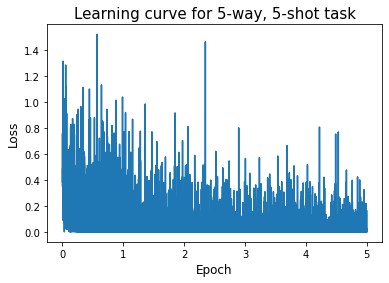

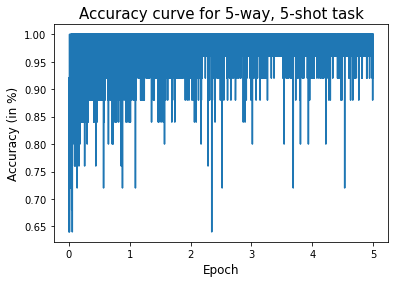

Model: "encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                                   

In [24]:
fsl_obj_5_5 = Few_Shot_learning(5, 5, 'proto_nets')
fsl_obj_5_5.automate(X_train, y_train, X_test, y_test, 5, "./Models/", True, True)

**2(a) Protonet: 5way, 1shot**

2022-11-21 10:47:20.868744: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-21 10:47:20.871795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-21 10:47:22.874203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-21 10:47:22.876119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-21 10:47:22.877959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:83:0

Model: "encoder_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv_l1 (Conv2D)             (None, 28, 28, 8)         224       
_________________________________________________________________
maxpool_l1 (MaxPooling2D)    (None, 13, 13, 8)         0         
_________________________________________________________________
conv_l2 (Conv2D)             (None, 13, 13, 16)        1168      
_________________________________________________________________
maxpool_l2 (MaxPooling2D)    (None, 6, 6, 16)          0         
_________________________________________________________________
batch_norm_l2 (BatchNormaliz (None, 6, 6, 16)          64        
_________________________________________________________________
conv_l3 (Conv2D)             (None, 6, 6, 32)      

2022-11-21 10:47:32.721313: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-21 10:47:37.796795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


After 1 epochs: loss = 3.614555316744372e-05, acc = 1.0
After 2 epochs: loss = 0.025179501622915268, acc = 1.0
After 3 epochs: loss = 0.006046938244253397, acc = 1.0
After 4 epochs: loss = 0.002270706929266453, acc = 1.0
After 5 epochs: loss = 0.008941130712628365, acc = 1.0


2022-11-21 11:10:04.202184: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Models/prototype_net_5way_1shot/assets
Training time of proto_nets is 22.743245780467987 minutes


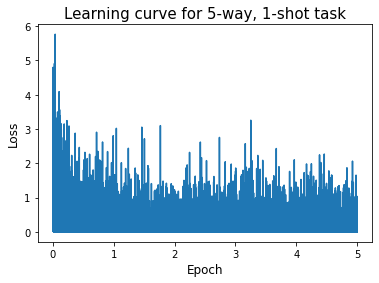

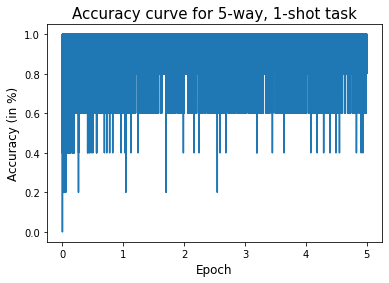

Model: "encoder_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv_l1 (Conv2D)             (None, 28, 28, 8)         224       
_________________________________________________________________
maxpool_l1 (MaxPooling2D)    (None, 13, 13, 8)         0         
_________________________________________________________________
conv_l2 (Conv2D)             (None, 13, 13, 16)        1168      
_________________________________________________________________
maxpool_l2 (MaxPooling2D)    (None, 6, 6, 16)          0         
_________________________________________________________________
batch_norm_l2 (BatchNormaliz (None, 6, 6, 16)          64        
_________________________________________________________________
conv_l3 (Conv2D)             (None, 6, 6, 32)      

In [14]:
fsl_obj_5_5 = Few_Shot_learning(5, 1, 'proto_nets')
#5 times more tasks than 5-way, 5-shot, (thus only doing 2 epoch): still same number of updates as above
#after getting the learning curve rescale it to 5 epochs
fsl_obj_5_5.automate(X_train, y_train, X_test, y_test, 5, "./Models/", True, True)

**2(b) MAML: 5way, 5shot**

Model: "maml_encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                              

After 1 epochs: loss = 10.03223991394043, acc = 0.8862500000000002
After 2 epochs: loss = 6.619584083557129, acc = 0.9200000000000003
After 3 epochs: loss = 5.074838161468506, acc = 0.9362500000000001
After 4 epochs: loss = 3.7473864555358887, acc = 0.9587500000000004
After 5 epochs: loss = 2.310032606124878, acc = 0.9737500000000003


INFO:tensorflow:Assets written to: ./Models/maml_net_5way_5shot\assets


INFO:tensorflow:Assets written to: ./Models/maml_net_5way_5shot\assets


Training time of maml is 30.483535770575205 minutes


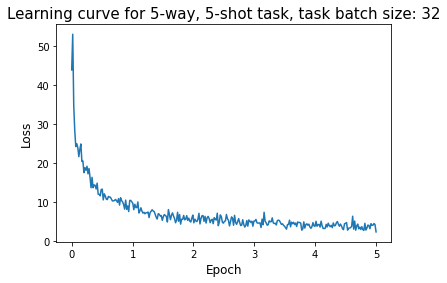

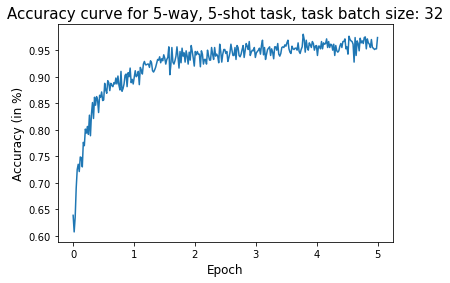

Model: "maml_encoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 conv_l1 (Conv2D)            (None, 28, 28, 8)         224       
                                                                 
 maxpool_l1 (MaxPooling2D)   (None, 13, 13, 8)         0         
                                                                 
 conv_l2 (Conv2D)            (None, 13, 13, 16)        1168      
                                                                 
 maxpool_l2 (MaxPooling2D)   (None, 6, 6, 16)          0         
                                                                 
 batch_norm_l2 (BatchNormali  (None, 6, 6, 16)         64        
 zation)                                                         
                                              

In [26]:
#paper says 32: as the task batch size: thus following it
fsl_obj_5_5 = Few_Shot_learning(5, 5, 'maml', 32)
fsl_obj_5_5.automate(X_train, y_train, X_test, y_test, 5, "./Models/", True, True)

**2(b) MAML: 5way, 1shot**

Model: "maml_encoder_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv_l1 (Conv2D)             (None, 28, 28, 8)         224       
_________________________________________________________________
maxpool_l1 (MaxPooling2D)    (None, 13, 13, 8)         0         
_________________________________________________________________
conv_l2 (Conv2D)             (None, 13, 13, 16)        1168      
_________________________________________________________________
maxpool_l2 (MaxPooling2D)    (None, 6, 6, 16)          0         
_________________________________________________________________
batch_norm_l2 (BatchNormaliz (None, 6, 6, 16)          64        
_________________________________________________________________
conv_l3 (Conv2D)             (None, 6, 6, 32) 

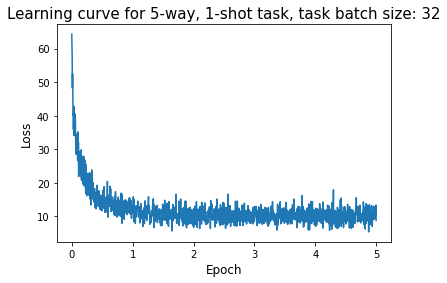

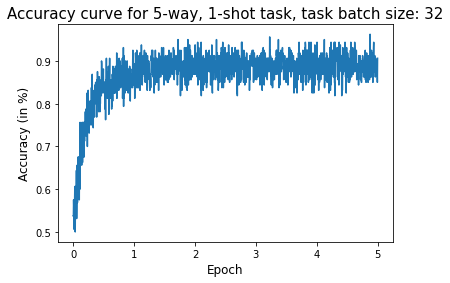

Model: "maml_encoder_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv_l1 (Conv2D)             (None, 28, 28, 8)         224       
_________________________________________________________________
maxpool_l1 (MaxPooling2D)    (None, 13, 13, 8)         0         
_________________________________________________________________
conv_l2 (Conv2D)             (None, 13, 13, 16)        1168      
_________________________________________________________________
maxpool_l2 (MaxPooling2D)    (None, 6, 6, 16)          0         
_________________________________________________________________
batch_norm_l2 (BatchNormaliz (None, 6, 6, 16)          64        
_________________________________________________________________
conv_l3 (Conv2D)             (None, 6, 6, 32) 

In [15]:
fsl_obj_5_5 = Few_Shot_learning(5, 1, 'maml', 32)
#5 times more tasks than 5-way, 5-shot, (thus only doing 2 epoch): still same number of updates as above
#after getting the learning curve rescale it to 5 epochs
fsl_obj_5_5.automate(X_train, y_train, X_test, y_test, 5, "./Models/", True, True)

**Compare results**

In [3]:
#inspired from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#plotter
def plot_accuracies_2group(proto, maml, baseline, labels, legends, __title__):
    
    x = np.arange(len(labels))  # the label locations
    width = 0.18  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    rects1 = ax.bar(x - width, proto, 2*width, label=legends[0])
    rects2 = ax.bar(x + width, maml, 2*width, label=legends[1])
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=20)
    ax.set_title(__title__, fontsize=25)
    ax.set_xticks(x, labels, fontsize=20)
    ax.axhline(y = baseline, color='black', linestyle = '--')
    
    ax.legend(fontsize=20)
    
    ax.bar_label(rects1, fontsize=20, padding=3)
    ax.bar_label(rects2, fontsize=20, padding=3)
    #fig.tight_layout()

    plt.show()

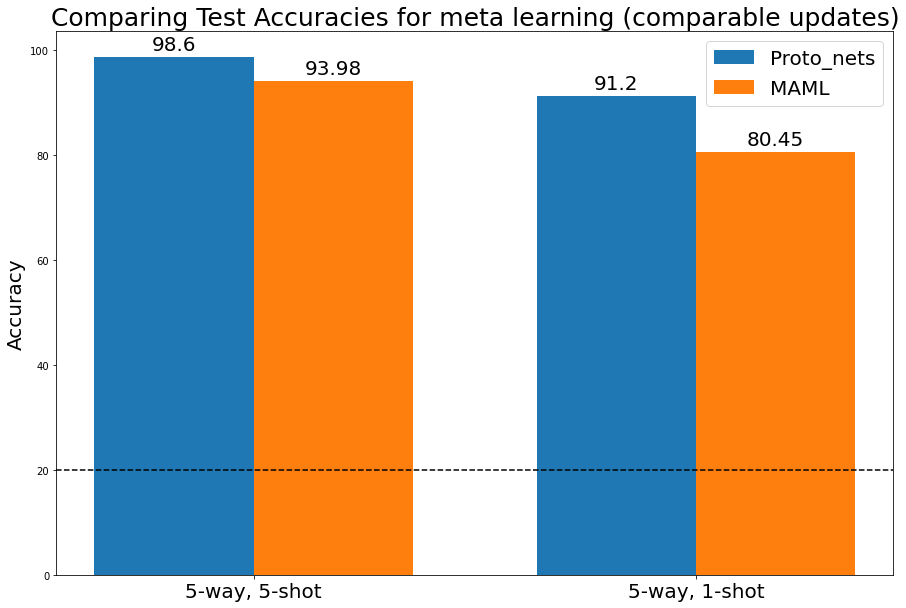

In [4]:
plot_accuracies_2group([98.60, 91.20], [93.98, 80.45], 20,  ["5-way, 5-shot", "5-way, 1-shot"], ["Proto_nets", "MAML"], "Comparing Test Accuracies for meta learning (comparable updates)")

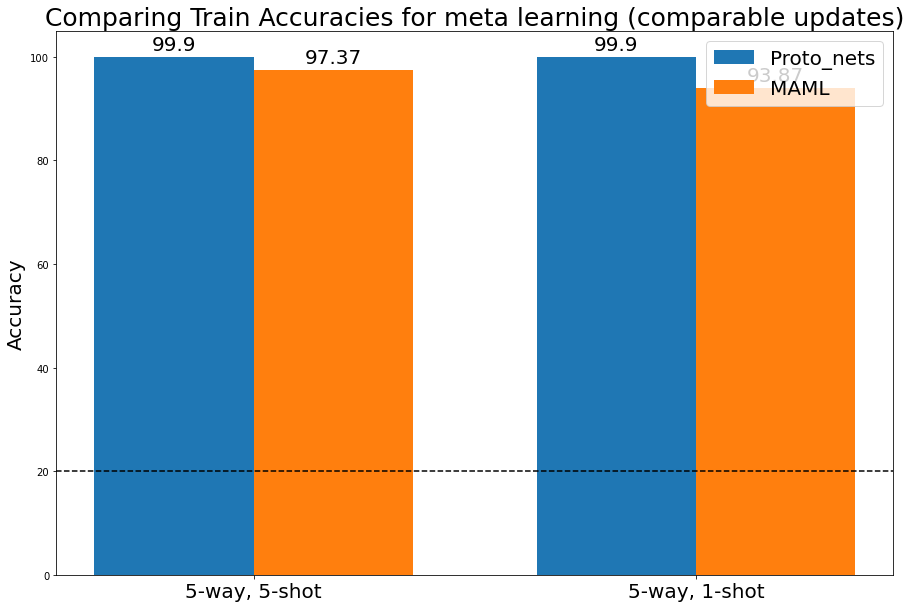

In [5]:
plot_accuracies_2group([99.90, 99.90], [97.37, 93.87], 20,  ["5-way, 5-shot", "5-way, 1-shot"], ["Proto_nets", "MAML"], "Comparing Train Accuracies for meta learning (comparable updates)")